
--- TEST AVEC ZONE 3×3 DÉCOUVERTE PAR LE ROBOT + FLOOD FILL ---

          🤖 MICROMOUSE SOLVER - DÉCOUVERTE DYNAMIQUE + FLOOD FILL - 32×32

[ÉTAPE 1] DÉTECTION DES MURS
------------------------------------------------------------------------------------------
✓ Image chargée: (1225, 1286, 3)
✓ Ratio murs (blanc): 24.0%

✓ Détection des murs (N, E, S, O) pour chaque cellule...
✓ Grille 32×32 analysée.
  • 1169 passages internes ouverts détectés.

[ÉTAPE 1.5] DÉTECTION DU POINT DE DÉPART
------------------------------------------------------------------------------------------

✓ Recherche de la position de départ parmi les coins...
  • Point de départ détecté à: (0, 31) avec 3 murs.
  • Cible heuristique initiale (centre du labyrinthe): (16, 16)

✓ Configuration du solveur (grille 32×32):
  • Départ: (0, 31)
  • Le robot va maintenant chercher la zone 3×3 en explorant, en visant le centre du labyrinthe initialement.

[ÉTAPE 2] EXPLORATION A* POUR DÉTECTER LA ZONE 3×3
------------------

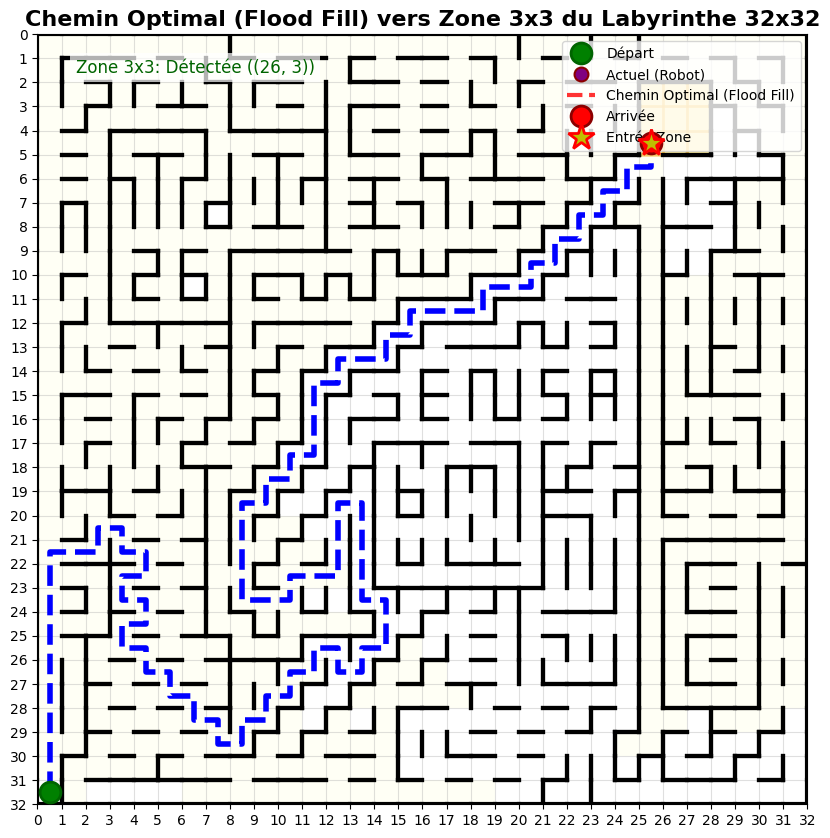

✓ Affichage statique du chemin final terminé.

[ÉTAPE 6] ANIMATION DE L'EXPLORATION A* (jusqu'à la détection de la zone)
------------------------------------------------------------------------------------------
✓ Animation de l'exploration créée avec 696 frames.
  • Enregistrement de l'animation en GIF vers outputs/exploration_animation_detect_3x3_32x32.gif (cela peut prendre un certain temps)...
✓ Animation GIF sauvegardée : outputs/exploration_animation_detect_3x3_32x32.gif


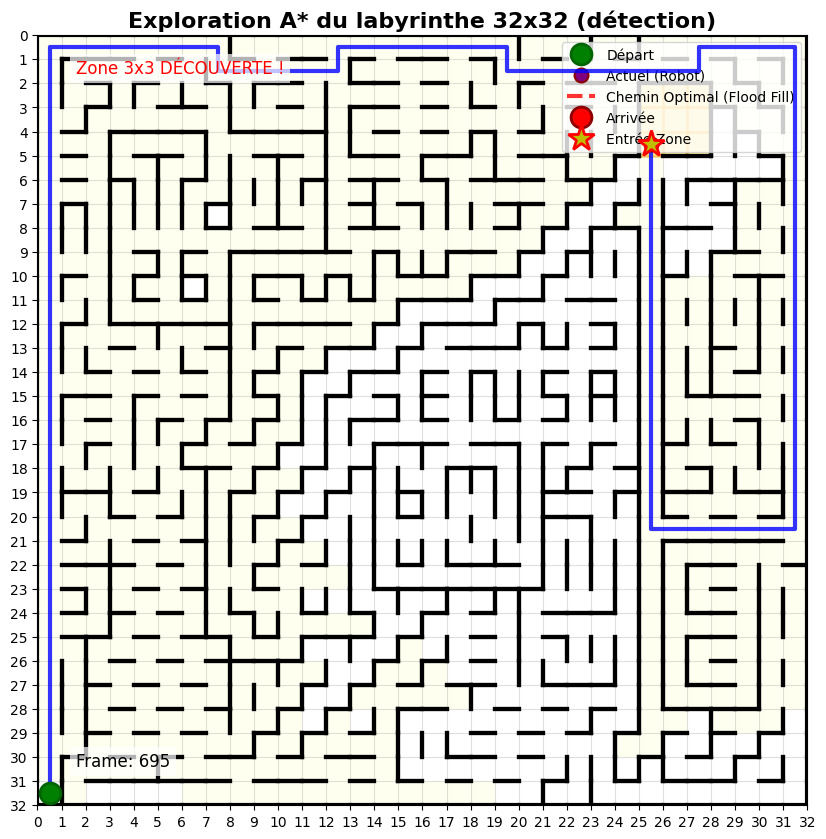


[ÉTAPE 7] RAPPORT
------------------------------------------------------------------------------------------
✓ Rapport: outputs/rapport_3x3_floodfill_32x32.txt

                              ✅ TERMINÉ AVEC SUCCÈS!



In [5]:
#!/usr/bin/env python3
"""
MicroMouse Solver - Version Dynamique AVEC ANIMATION et Flood Fill après découverte
Le robot (l'algorithme de recherche) détecte la zone 3x3 pendant l'exploration.
Une fois la zone détectée, un Flood Fill est utilisé pour trouver le chemin optimal.
Affiche une animation des étapes d'exploration.
"""

import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.animation import FuncAnimation
import heapq
from collections import deque
from typing import List, Tuple, Set, Optional, Dict
import os
import copy
import time

# =============================================================================
# WallMazeDetector (inchangé)
# =============================================================================
class WallMazeDetector:
    def __init__(self, image_path: str, grid_size: int = 16):
        self.image_path = image_path
        self.grid_size = grid_size
        self.original_image = None
        self.binary_image = None
        self.grid = np.zeros((self.grid_size, self.grid_size), dtype=int)

        self.cell_h = 0
        self.cell_w = 0

    def load_and_process(self):
        self.original_image = cv2.imread(self.image_path)
        if self.original_image is None:
            raise ValueError(f"Impossible de charger: {self.image_path}")

        gray = cv2.cvtColor(self.original_image, cv2.COLOR_BGR2GRAY)
        _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
        kernel = np.ones((3, 3), np.uint8)
        binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=1)

        self.binary_image = binary

        h, w = self.binary_image.shape
        self.cell_h = h / self.grid_size
        self.cell_w = w / self.grid_size

        print(f"✓ Image chargée: {self.original_image.shape}")
        print(f"✓ Ratio murs (blanc): {np.mean(binary==255):.1%}")

        return binary

    def _check_wall_region(self, y_start, y_end, x_start, x_end, threshold=0.4):
        y_start, y_end = int(max(0, y_start)), int(min(self.binary_image.shape[0], y_end))
        x_start, x_end = int(max(0, x_start)), int(min(self.binary_image.shape[1], x_end))

        region = self.binary_image[y_start:y_end, x_start:x_end]

        if region.size == 0:
            return False

        wall_ratio = np.mean(region == 255)
        return wall_ratio > threshold

    def detect_walls(self):
        if self.binary_image is None:
            self.load_and_process()

        h, w = self.binary_image.shape
        wall_thickness_y = max(2, int(self.cell_h * 0.1))
        wall_thickness_x = max(2, int(self.cell_w * 0.1))
        margin_y = int(self.cell_h * 0.2)
        margin_x = int(self.cell_w * 0.2)

        self.grid = np.zeros((self.grid_size, self.grid_size), dtype=int)

        print("\n✓ Détection des murs (N, E, S, O) pour chaque cellule...")

        for i in range(self.grid_size):  # Ligne (y)
            for j in range(self.grid_size):  # Colonne (x)

                y_north_wall = i * self.cell_h
                y_south_wall = (i + 1) * self.cell_h
                x_west_wall = j * self.cell_w
                x_east_wall = (j + 1) * self.cell_w

                if i == 0 or self._check_wall_region(
                    y_north_wall - wall_thickness_y, y_north_wall + wall_thickness_y,
                    x_west_wall + margin_x, x_east_wall - margin_x
                ):
                    self.grid[i, j] |= 1  # Mur NORD

                if i == self.grid_size - 1 or self._check_wall_region(
                    y_south_wall - wall_thickness_y, y_south_wall + wall_thickness_y,
                    x_west_wall + margin_x, x_east_wall - margin_x
                ):
                    self.grid[i, j] |= 4  # Mur SUD

                if j == 0 or self._check_wall_region(
                    y_north_wall + margin_y, y_south_wall - margin_y,
                    x_west_wall - wall_thickness_x, x_west_wall + wall_thickness_x
                ):
                    self.grid[i, j] |= 8  # Mur OUEST

                if j == self.grid_size - 1 or self._check_wall_region(
                    y_north_wall + margin_y, y_south_wall - margin_y,
                    x_east_wall - wall_thickness_x, x_east_wall + wall_thickness_x
                ):
                    self.grid[i, j] |= 2  # Mur EST

        open_passages = 0
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                walls = self.grid[i, j]
                if not (walls & 1) and i > 0: open_passages += 1
                if not (walls & 2) and j < self.grid_size - 1: open_passages += 1

        print(f"✓ Grille {self.grid_size}×{self.grid_size} analysée.")
        print(f"  • {open_passages} passages internes ouverts détectés.")

        return self.grid

    def detect_start_position(self) -> Optional[Tuple[int, int]]:
        """
        Détecte la position de départ dans l'un des quatre coins.
        Le point de départ est la cellule dans un coin qui a exactement trois murs.
        Retourne (x, y) de la cellule de départ ou None si non trouvé.
        """
        if self.grid is None or self.grid.size == 0:
            raise ValueError("La grille des murs n'a pas été détectée. Appelez detect_walls() d'abord.")

        corners = [
            (0, 0),                                 # Coin supérieur gauche (x, y)
            (self.grid_size - 1, 0),                # Coin supérieur droit
            (0, self.grid_size - 1),                # Coin inférieur gauche
            (self.grid_size - 1, self.grid_size - 1)  # Coin inférieur droit
        ]

        print("\n✓ Recherche de la position de départ parmi les coins...")

        for x, y in corners:
            walls_code = self.grid[y, x]
            num_walls = bin(walls_code).count('1')

            if num_walls == 3:
                print(f"  • Point de départ détecté à: ({x}, {y}) avec {num_walls} murs.")
                return (x, y)

        print("✗ Aucun point de départ valide (cellule de coin avec 3 murs) n'a été trouvé.")
        return None

# =============================================================================
# GoalZoneDetector_Internal (inchangé)
# =============================================================================
class GoalZoneDetector_Internal:
    def __init__(self, grid, size):
        self.grid = grid
        self.size = size

    def _check_3x3_zone(self, top_y: int, left_x: int) -> Optional[Tuple[Tuple[int, int], Set[Tuple[int, int]], Tuple[int, int]]]:
        if top_y < 0 or left_x < 0 or top_y + 2 >= self.size or left_x + 2 >= self.size:
            return None

        zone_cells = set()
        for dy in range(3):
            for dx in range(3):
                zone_cells.add((left_x + dx, top_y + dy))
        openings = []

        for x, y in zone_cells:
            walls = self.grid[y, x]
            if not (walls & 1) and y > 0:
                neighbor = (x, y - 1)
                if neighbor not in zone_cells: openings.append((x, y))
            if not (walls & 4) and y < self.size - 1:
                neighbor = (x, y + 1)
                if neighbor not in zone_cells: openings.append((x, y))
            if not (walls & 8) and x > 0:
                neighbor = (x - 1, y)
                if neighbor not in zone_cells: openings.append((x, y))
            if not (walls & 2) and x < self.size - 1:
                neighbor = (x + 1, y)
                if neighbor not in zone_cells: openings.append((x, y))

        if len(openings) != 1: return None

        for x, y in zone_cells:
            walls = self.grid[y, x]
            if (x, y - 1) in zone_cells and ((walls & 1) or (self.grid[y - 1, x] & 4)): return None
            if (x, y + 1) in zone_cells and ((walls & 4) or (self.grid[y + 1, x] & 1)): return None
            if (x - 1, y) in zone_cells and ((walls & 8) or (self.grid[y, x - 1] & 2)): return None
            if (x + 1, y) in zone_cells and ((walls & 2) or (self.grid[y, x + 1] & 8)): return None

        center = (left_x + 1, top_y + 1)
        entry_point = openings[0]
        return (center, zone_cells, entry_point)


# =============================================================================
# MazeSolverWith3x3Goal (MODIFIÉ pour s'arrêter après la découverte et pour Flood Fill)
# =============================================================================
class MazeSolverWith3x3Goal:
    def __init__(self, grid, start_pos: Tuple[int, int]):
        self.grid = grid
        self.size = len(grid)
        self.start = start_pos

        self.goal_center: Optional[Tuple[int, int]] = None
        self.goal_set: Optional[Set[Tuple[int, int]]] = None
        self.entry_point: Optional[Tuple[int, int]] = None
        self.goal: Optional[Tuple[int, int]] = None # La cellule spécifique de la zone 3x3 atteinte

        self.maze_center = (self.size // 2, self.size // 2)
        print(f"  • Cible heuristique initiale (centre du labyrinthe): {self.maze_center}")

        self.goal_detector_internal = GoalZoneDetector_Internal(grid, self.size)

        self.animation_frames: List[Dict] = []
        self.final_path_found_by_floodfill: List[Tuple[int, int]] = [] # Pour stocker le chemin Flood Fill
        self.explored_cells_during_astar: Set[Tuple[int, int]] = set() # Pour stocker les cellules explorées par A*

        print(f"\n✓ Configuration du solveur (grille {self.size}×{self.size}):")
        print(f"  • Départ: {self.start}")
        print(f"  • Le robot va maintenant chercher la zone 3×3 en explorant, en visant le centre du labyrinthe initialement.")

    def get_neighbors(self, pos: Tuple[int, int]) -> List[Tuple[int, int]]:
        x, y = pos
        walls = self.grid[y, x]
        neighbors = []

        if y > 0 and not (walls & 1) and not (self.grid[y - 1, x] & 4): neighbors.append((x, y - 1))
        if y < self.size - 1 and not (walls & 4) and not (self.grid[y + 1, x] & 1): neighbors.append((x, y + 1))
        if x > 0 and not (walls & 8) and not (self.grid[y, x - 1] & 2): neighbors.append((x - 1, y))
        if x < self.size - 1 and not (walls & 2) and not (self.grid[y, x + 1] & 8): neighbors.append((x + 1, y))

        return neighbors

    def a_star_explore_for_goal_detection(self, turn_penalty: int = 5) -> Tuple[bool, Optional[Tuple[Tuple[int, int], Set[Tuple[int, int]], Tuple[int, int]]]]:
        """
        Exécute A* pour explorer le labyrinthe et détecter la zone 3x3.
        S'arrête dès que la zone est détectée.
        Retourne un booléen indiquant si la zone a été trouvée et les infos de la zone si oui.
        """
        def heuristic(pos: Tuple[int, int]) -> int:
            return abs(pos[0] - self.maze_center[0]) + abs(pos[1] - self.maze_center[1])

        open_set = [(heuristic(self.start), 0, self.start, None)]
        came_from = {}
        g_score = {self.start: 0}
        closed_set = set() # Les cellules visitées par A*
        
        self.animation_frames = []
        self._record_animation_frame(current=None, path=[], explored=set(), came_from={}, goal_found_in_frame=None)

        print(f"  • Lancement de A* en mode exploration (vers le centre) avec pénalité de virage = {turn_penalty}")

        while open_set:
            f, g, current, parent = heapq.heappop(open_set)

            if current in closed_set:
                continue

            closed_set.add(current)
            came_from[current] = parent
            self.explored_cells_during_astar.add(current) # Stocker les cellules explorées

            goal_found_in_frame = False

            # Détection de la zone 3x3
            if self.goal_set is None: # N'essaie de détecter que si la zone n'est pas déjà trouvée
                for dy_offset in range(3):
                    for dx_offset in range(3):
                        test_top_y = current[1] - dy_offset
                        test_left_x = current[0] - dx_offset

                        potential_goal_zone = self.goal_detector_internal._check_3x3_zone(
                            test_top_y, test_left_x
                        )
                        if potential_goal_zone:
                            self.goal_center, self.goal_set, self.entry_point = potential_goal_zone
                            print(f"\n✓ Zone 3×3 détectée par le robot à partir de ({current[0]}, {current[1]})!")
                            print(f"  • Centre: {self.goal_center}")
                            print(f"  • Point d'entrée: {self.entry_point}")
                            print(f"  • Cellules de la zone: {sorted(self.goal_set)}")
                            goal_found_in_frame = True
                            # Le robot s'arrête ici après détection!
                            self._record_animation_frame(
                                current=current,
                                path=self._reconstruct_path(came_from, current),
                                explored=copy.copy(closed_set),
                                came_from=copy.copy(came_from),
                                goal_found_in_frame=goal_found_in_frame
                            )
                            return True, potential_goal_zone # Retourne immédiatement

            current_dir = None
            if parent:
                current_dir = (current[0] - parent[0], current[1] - parent[1])

            for neighbor in self.get_neighbors(current):
                if neighbor == parent or neighbor in closed_set:
                    continue

                move_cost = 1
                neighbor_dir = (neighbor[0] - current[0], neighbor[1] - current[1])

                if current_dir and current_dir != neighbor_dir:
                    move_cost += turn_penalty

                tentative_g = g + move_cost

                if neighbor not in g_score or tentative_g < g_score[neighbor]:
                    g_score[neighbor] = tentative_g
                    f_score = tentative_g + heuristic(neighbor)
                    heapq.heappush(open_set, (f_score, tentative_g, neighbor, current))

            self._record_animation_frame(
                current=current,
                path=self._reconstruct_path(came_from, current),
                explored=copy.copy(closed_set),
                came_from=copy.copy(came_from),
                goal_found_in_frame=goal_found_in_frame
            )
        
        # Si la boucle se termine sans trouver la zone 3x3
        print("\n✗ Aucune zone 3×3 valide n'a été trouvée pendant l'exploration.")
        self._record_animation_frame(
            current=None,
            path=[],
            explored=copy.copy(closed_set),
            came_from=copy.copy(came_from),
            goal_found_in_frame=False
        )
        return False, None

    def flood_fill_pathfinding(self) -> List[Tuple[int, int]]:
        """
        Effectue un Flood Fill à partir des cellules de la zone 3x3 pour trouver le chemin optimal
        vers la cellule de départ.
        """
        if not self.goal_set:
            return []

        print("\n  • Lancement du Flood Fill pour trouver le chemin optimal vers la zone 3x3...")

        distances = {} # Stores minimum distance from any goal cell to this cell
        queue = deque()

        # Initialize Flood Fill from all cells in the goal_set
        for gx, gy in self.goal_set:
            distances[(gx, gy)] = 0
            queue.append(((gx, gy), 0)) # (position, distance)

        min_dist_to_start = float('inf')
        start_cell_in_goal_set = None

        # Execute BFS-like Flood Fill
        while queue:
            (cx, cy), dist = queue.popleft()

            if (cx,cy) == self.start:
                min_dist_to_start = dist
                start_cell_in_goal_set = (cx,cy) # This would be the "goal" in path reconstruction
                # No need to break, continue filling to ensure all cells get shortest distance FROM goal
                # In MicroMouse, we want the shortest path to *any* cell of the goal set,
                # so filling from all goal cells outwards is correct.

            for nx, ny in self.get_neighbors((cx, cy)):
                if (nx, ny) not in distances or distances[(nx, ny)] > dist + 1:
                    distances[(nx, ny)] = dist + 1
                    queue.append(((nx, ny), dist + 1))

        # Reconstruct path from start to a goal cell using calculated distances
        path = []
        if self.start in distances:
            current = self.start
            while current not in self.goal_set:
                path.append(current)
                min_neighbor_dist = float('inf')
                next_cell = None
                
                found_next_step = False
                for nx, ny in self.get_neighbors(current):
                    if (nx, ny) in distances and distances[(nx, ny)] < min_neighbor_dist:
                        min_neighbor_dist = distances[(nx, ny)]
                        next_cell = (nx, ny)
                        found_next_step = True
                
                if not found_next_step:
                    # This should not happen if start is reachable, but for safety
                    print(f"Avertissement: Impossible de trouver le prochain pas depuis {current} vers la zone cible.")
                    return [] # Or raise error
                current = next_cell
            
            path.append(current) # Add the final goal cell
            self.goal = current # Set the actual goal cell reached by Flood Fill

        print(f"✓ Flood Fill terminé. Chemin optimal trouvé de longueur: {len(path)} cellules.")
        return path


    def _reconstruct_path(self, came_from: Dict[Tuple[int, int], Tuple[int, int]], current: Tuple[int, int]) -> List[Tuple[int, int]]:
        path = []
        # Parfois came_from ne contient pas le start si c'est le seul point
        if current not in came_from and current == self.start:
            return [self.start]

        while current is not None:
            path.append(current)
            current = came_from.get(current)
        path.reverse()
        return path

    def _record_animation_frame(self, current: Optional[Tuple[int, int]], path: List[Tuple[int, int]], explored: Set[Tuple[int, int]], came_from: Dict, goal_found_in_frame: Optional[bool]):
        """Enregistre l'état actuel du solver pour une frame d'animation."""
        self.animation_frames.append({
            'current_pos': current,
            'path_to_current': copy.copy(path),
            'explored_cells': copy.copy(explored),
            'goal_center': copy.copy(self.goal_center),
            'goal_set': copy.copy(self.goal_set),
            'entry_point': copy.copy(self.entry_point),
            'actual_goal_reached': copy.copy(self.goal),
            'goal_found_this_frame': goal_found_in_frame
        })

    def extract_arcs(self, path):
        if len(path) < 2: return []
        arcs = []
        arc_start = path[0]
        current_direction = None
        for i in range(len(path) - 1):
            x1, y1 = path[i]
            x2, y2 = path[i + 1]
            direction = (x2 - x1, y2 - y1)
            if current_direction is None:
                current_direction = direction
            elif direction != current_direction:
                arc_length = abs(path[i][0] - arc_start[0]) + abs(path[i][1] - arc_start[1]) + 1
                arcs.append({
                    'id': len(arcs) + 1, 'start': arc_start, 'end': path[i],
                    'direction': current_direction, 'length': arc_length,
                    'cells': self._get_cells_in_arc(arc_start, path[i])
                })
                arc_start = path[i]
                current_direction = direction
        arc_length = abs(path[-1][0] - arc_start[0]) + abs(path[-1][1] - arc_start[1]) + 1
        arcs.append({
            'id': len(arcs) + 1, 'start': arc_start, 'end': path[-1],
            'direction': current_direction, 'length': arc_length,
            'cells': self._get_cells_in_arc(arc_start, path[-1])
        })
        return arcs

    def _get_cells_in_arc(self, start, end):
        cells = []
        x1, y1 = start
        x2, y2 = end
        if y1 == y2: step = 1 if x2 > x1 else -1; [cells.append((x, y1)) for x in range(x1, x2 + step, step)]
        elif x1 == x2: step = 1 if y2 > y1 else -1; [cells.append((x1, y)) for y in range(y1, y2 + step, step)]
        return cells


# =============================================================================
# AdvancedVisualizer (MODIFIÉ pour l'animation et Flood Fill)
# =============================================================================
class AdvancedVisualizer:
    def __init__(self, detector: WallMazeDetector, solver: MazeSolverWith3x3Goal):
        self.detector = detector
        self.solver = solver
        self.size = solver.size
        self.fig: Optional[plt.Figure] = None
        self.ax: Optional[plt.Axes] = None
        self.path_line: Optional[plt.Line2D] = None
        self.start_marker: Optional[plt.Line2D] = None
        self.current_marker: Optional[plt.Line2D] = None
        self.goal_marker: Optional[plt.Line2D] = None
        self.entry_marker: Optional[plt.Line2D] = None
        self.explored_rects: List[Rectangle] = []
        self.goal_zone_rects: List[Rectangle] = []
        self.goal_text: Optional[plt.Text] = None
        self.frame_text: Optional[plt.Text] = None
        self.final_path_line: Optional[plt.Line2D] = None # Pour le chemin final Flood Fill

    def _draw_base_grid(self, title: str):
        self.fig, self.ax = plt.subplots(figsize=(10, 10))
        self.ax.set_facecolor('white')

        for i in range(self.size):
            for j in range(self.size):
                walls = self.detector.grid[i, j]
                x, y = j, i
                if walls & 1: self.ax.plot([x, x + 1], [y, y], 'k-', linewidth=3, zorder=5)
                if walls & 2: self.ax.plot([x + 1, x + 1], [y, y + 1], 'k-', linewidth=3, zorder=5)
                if walls & 4: self.ax.plot([x, x + 1], [y + 1, y + 1], 'k-', linewidth=3, zorder=5)
                if walls & 8: self.ax.plot([x, x], [y, y + 1], 'k-', linewidth=3, zorder=5)

        major_ticks = np.arange(0, self.size + 1, 1)
        self.ax.set_xticks(major_ticks)
        self.ax.set_yticks(major_ticks)
        self.ax.grid(which='major', alpha=0.4, linestyle='-', zorder=0)

        self.ax.set_xlim(0, self.size)
        self.ax.set_ylim(0, self.size)
        self.ax.set_aspect('equal')
        self.ax.invert_yaxis()
        self.ax.set_title(title, fontsize=16, fontweight='bold')

        sx, sy = self.solver.start
        self.start_marker, = self.ax.plot(sx + 0.5, sy + 0.5, 'go', markersize=15, markeredgecolor='darkgreen', markeredgewidth=2, label='Départ', zorder=10)

        self.current_marker, = self.ax.plot([], [], 'o', color='purple', markersize=10, markeredgecolor='darkred', markeredgewidth=1.5, label='Actuel (Robot)', zorder=9)
        self.path_line, = self.ax.plot([], [], 'b-', linewidth=3, alpha=0.8, zorder=6) # Chemin A* d'exploration
        self.final_path_line, = self.ax.plot([], [], 'r--', linewidth=3, alpha=0.8, zorder=7, label='Chemin Optimal (Flood Fill)') # Pour le chemin Flood Fill
        self.goal_marker, = self.ax.plot([], [], 'ro', markersize=15, markeredgecolor='darkred', markeredgewidth=2, label='Arrivée', zorder=10)
        self.entry_marker, = self.ax.plot([], [], 'y*', markersize=20, markeredgecolor='red', markeredgewidth=2, label='Entrée Zone', zorder=10)
        self.goal_text = self.ax.text(0.05, 0.95, '', transform=self.ax.transAxes, fontsize=12, color='darkred', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'), zorder=11)
        self.frame_text = self.ax.text(0.05, 0.05, '', transform=self.ax.transAxes, fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'), zorder=11)

        self.ax.legend(loc='upper right')

    def draw_final_path(self, path: List[Tuple[int, int]], goal_zone_info: Optional[Tuple[Tuple[int, int], Set[Tuple[int, int]], Tuple[int, int]]]):
        """Affiche le chemin final (Flood Fill) et la zone 3x3 sur une image statique."""
        self._draw_base_grid(f'Chemin Optimal (Flood Fill) vers Zone 3x3 du Labyrinthe {self.size}x{self.size}')

        # Dessiner les cellules explorées par A* (pour montrer la connaissance acquise)
        for pos in self.solver.explored_cells_during_astar:
            if pos != self.solver.start:
                rect = Rectangle((pos[0], pos[1]), 1, 1, facecolor='lightyellow', alpha=0.3, zorder=1)
                self.ax.add_patch(rect)
                self.explored_rects.append(rect)

        # Dessiner la zone 3x3 si détectée
        if goal_zone_info:
            goal_center, goal_set, entry_point = goal_zone_info
            for g in goal_set:
                rect = Rectangle((g[0], g[1]), 1, 1, facecolor='gold', alpha=0.4, edgecolor='orange', linewidth=2, zorder=2)
                self.ax.add_patch(rect)
                self.goal_zone_rects.append(rect)

            # Marquer le point d'entrée
            ex, ey = entry_point
            self.entry_marker.set_data([ex + 0.5], [ey + 0.5])
            self.goal_text.set_text(f"Zone 3x3: Détectée ({goal_center})")
            self.goal_text.set_color('darkgreen')

            # Marquer la cible finale atteinte par Flood Fill
            if self.solver.goal:
                gx, gy = self.solver.goal
                self.goal_marker.set_data([gx + 0.5], [gy + 0.5])
        else:
            self.goal_text.set_text('Zone 3x3: Non détectée')
            self.goal_text.set_color('darkred')

        # Dessiner le chemin final du Flood Fill
        if path:
            path_px = [p[0] + 0.5 for p in path]
            path_py = [p[1] + 0.5 for p in path]
            self.final_path_line.set_data(path_px, path_py)
            self.final_path_line.set_color('blue')
            self.final_path_line.set_linewidth(4)
            self.final_path_line.set_alpha(1.0)
        
        # Masquer les éléments d'exploration
        self.current_marker.set_visible(False)
        self.frame_text.set_visible(False)
        self.path_line.set_visible(False) # Le chemin A* d'exploration n'est pas le chemin final

        plt.show(block=False)
        plt.pause(2)
        plt.close(self.fig)
        print("✓ Affichage statique du chemin final terminé.")

    def _update_animation(self, frame_data: Dict, frame_num: int):
        """Met à jour les éléments de l'animation pour chaque frame."""
        for rect in self.explored_rects + self.goal_zone_rects:
            rect.remove()
        self.explored_rects.clear()
        self.goal_zone_rects.clear()
        
        # Le chemin final Flood Fill n'est pas dessiné pendant l'animation d'exploration
        self.final_path_line.set_data([], [])

        # Dessiner les cellules explorées par A*
        for pos in frame_data['explored_cells']:
            if pos != self.solver.start:
                rect = Rectangle((pos[0], pos[1]), 1, 1, facecolor='lightyellow', alpha=0.5, zorder=1)
                self.ax.add_patch(rect)
                self.explored_rects.append(rect)

        # Dessiner la zone 3x3 si détectée
        if frame_data['goal_set']:
            for g in frame_data['goal_set']:
                rect = Rectangle((g[0], g[1]), 1, 1, facecolor='gold', alpha=0.4, edgecolor='orange', linewidth=2, zorder=2)
                self.ax.add_patch(rect)
                self.goal_zone_rects.append(rect)

            ex, ey = frame_data['entry_point']
            self.entry_marker.set_data([ex + 0.5], [ey + 0.5])
            if frame_data['goal_found_this_frame']:
                 self.goal_text.set_text("Zone 3x3 DÉCOUVERTE !")
                 self.goal_text.set_color('red')
            else:
                self.goal_text.set_text(f"Zone 3x3 trouvée (prête pour Flood Fill)")
                self.goal_text.set_color('darkgreen')
        else:
            self.entry_marker.set_data([], [])
            self.goal_text.set_text('Zone 3x3: Non détectée (vise le centre)')

        # Dessiner le chemin A* vers la cellule actuelle
        path_px = [p[0] + 0.5 for p in frame_data['path_to_current']]
        path_py = [p[1] + 0.5 for p in frame_data['path_to_current']]
        self.path_line.set_data(path_px, path_py)
        self.path_line.set_color('blue') # Couleur distinctive pour l'exploration A*
        self.path_line.set_linewidth(3)
        self.path_line.set_alpha(0.8)


        # Marquer la position actuelle du robot
        if frame_data['current_pos']:
            cx, cy = frame_data['current_pos']
            self.current_marker.set_data([cx + 0.5], [cy + 0.5])
            self.current_marker.set_visible(True)
        else:
            self.current_marker.set_data([], [])
            self.current_marker.set_visible(False)

        # La cible finale (goal_marker) n'est pas visible pendant l'exploration A*
        self.goal_marker.set_data([], [])

        self.frame_text.set_text(f'Frame: {frame_num}')
        return [self.path_line, self.final_path_line, self.current_marker, self.goal_marker, self.entry_marker, self.goal_text, self.frame_text] + self.explored_rects + self.goal_zone_rects

    def animate_exploration(self, interval_ms: int = 100):
        """Crée et affiche l'animation de l'exploration A*."""
        if not self.solver.animation_frames:
            print("Aucune donnée d'animation enregistrée.")
            return

        self._draw_base_grid(f'Exploration A* du labyrinthe {self.size}x{self.size} (détection)')

        anim = FuncAnimation(
            self.fig,
            lambda frame_num: self._update_animation(self.solver.animation_frames[frame_num], frame_num),
            frames=len(self.solver.animation_frames),
            interval=interval_ms,
            blit=True,
            repeat=False
        )

        print(f"✓ Animation de l'exploration créée avec {len(self.solver.animation_frames)} frames.")

        gif_path = f'outputs/exploration_animation_detect_3x3_{self.size}x{self.size}.gif'
        try:
            print(f"  • Enregistrement de l'animation en GIF vers {gif_path} (cela peut prendre un certain temps)...")

            new_fps = 200
            anim.save(gif_path, writer='pillow', fps=new_fps)

            print(f"✓ Animation GIF sauvegardée : {gif_path}")
        except Exception as e:
            print(f"✗ ERREUR lors de l'enregistrement du GIF : {e}")
            print("Assurez-vous que 'pillow' est installé (pip install Pillow) et 'imagemagick' si vous utilisez d'autres writers.")

        plt.show()


# =============================================================================
# save_arcs_report (inchangé, mais utilise le chemin final du Flood Fill)
# =============================================================================
def save_arcs_report(path, arcs, solver_instance: MazeSolverWith3x3Goal, output_file='outputs/arcs_zone_3x3_floodfill.txt'):
    direction_symbols = {
        (0, -1): '↑ NORD', (0, 1): '↓ SUD', (1, 0): '→ EST', (-1, 0): '← OUEST', None: '? INCONNU'
    }

    with open(output_file, 'w', encoding='utf-8') as f:
        f.write("="*90 + "\n")
        f.write(" "*10 + "🤖 RAPPORT DE NAVIGATION VERS ZONE 3×3 (DÉTECTION DYNAMIQUE + FLOOD FILL)\n")
        f.write("="*90 + "\n\n")

        if solver_instance.goal_set and solver_instance.entry_point and solver_instance.goal_center:
            f.write(f"📍 INFORMATIONS SUR LA ZONE 3×3 DÉTECTÉE\n")
            f.write("-"*90 + "\n")
            f.write(f"  • Centre de la zone : {solver_instance.goal_center}\n")
            f.write(f"  • Point d'entrée    : {solver_instance.entry_point}\n")
            f.write(f"  • Cellules de la zone: {sorted(solver_instance.goal_set)}\n\n")
        else:
            f.write("📍 Aucune zone 3×3 n'a été détectée par le robot pendant l'exploration.\n\n")

        f.write(f"📊 STATISTIQUES DU CHEMIN\n")
        f.write("-"*90 + "\n")
        if path:
            f.write(f"  • Longueur totale   : {len(path)} cellules\n")
            f.write(f"  • Nombre d'arcs     : {len(arcs)}\n")
            f.write(f"  • Nombre de virages : {len(arcs) - 1}\n")
            if arcs:
                avg_length = sum(arc['length'] for arc in arcs) / len(arcs)
                f.write(f"  • Longueur moy/arc  : {avg_length:.1f} cellules\n")
        else:
            f.write("  • Aucun chemin trouvé.\n")

        f.write("\n" + "="*90 + "\n\n")

        for arc in arcs:
            direction = direction_symbols.get(arc['direction'], '?')
            f.write(f"📍 ARC #{arc['id']}\n")
            f.write("-"*90 + "\n")
            f.write(f"  Départ    : {arc['start']}\n")
            f.write(f"  Arrivée   : {arc['end']}\n")
            f.write(f"  Direction : {direction}\n")
            f.write(f"  Longueur  : {arc['length']} cellules\n")
            f.write(f"  Cellules  : {arc['cells']}\n\n")

        if path:
            f.write("="*90 + "\n")
            f.write("📋 CHEMIN COMPLET (CALCULÉ PAR FLOOD FILL)\n")
            f.write("="*90 + "\n\n")

            for i, pos in enumerate(path):
                marker = ""
                if pos == path[0]:
                    marker = " ← DÉPART"
                elif solver_instance.goal_set and pos in solver_instance.goal_set:
                    marker = " ← ZONE 3×3"
                if solver_instance.entry_point and pos == solver_instance.entry_point:
                    marker += " (ENTRÉE)"

                f.write(f"  Étape {i+1:3d}: {pos}{marker}\n")


# =============================================================================
# main (MODIFIÉ pour les deux phases)
# =============================================================================
def main(image_path: str,
         grid_size: int = 32):

    print("\n" + "="*90)
    print(" "*10 + f"🤖 MICROMOUSE SOLVER - DÉCOUVERTE DYNAMIQUE + FLOOD FILL - {grid_size}×{grid_size}")
    print("="*90)

    os.makedirs('outputs', exist_ok=True)

    start_time = time.time()

    # Étape 1: Détection des murs
    print("\n[ÉTAPE 1] DÉTECTION DES MURS")
    print("-"*90)
    detector = WallMazeDetector(image_path, grid_size=grid_size)
    detector.load_and_process()
    grid = detector.detect_walls()

    # Étape 1.5: Détection du point de départ
    print("\n[ÉTAPE 1.5] DÉTECTION DU POINT DE DÉPART")
    print("-"*90)
    start_pos = detector.detect_start_position()

    if start_pos is None:
        print("\n❌ ERREUR: Impossible de détecter un point de départ valide. Arrêt du programme.")
        return

    solver = MazeSolverWith3x3Goal(grid, start_pos)

    # --- Phase 2: Le robot explore et détecte la zone 3x3 (avec A*) ---
    print("\n[ÉTAPE 2] EXPLORATION A* POUR DÉTECTER LA ZONE 3×3")
    print("-"*90)
    goal_found, goal_zone_info = solver.a_star_explore_for_goal_detection(turn_penalty=5)

    if not goal_found:
        print("\n❌ ERREUR: Aucune zone 3×3 valide n'a été trouvée pendant l'exploration du robot!")
        # Afficher l'animation de l'exploration jusqu'à la fin de la recherche A*
        viz = AdvancedVisualizer(detector, solver)
        viz.animate_exploration(interval_ms=50)
        return
    
    # --- Phase 3: Calcul du chemin optimal avec Flood Fill ---
    print("\n[ÉTAPE 3] CALCUL DU CHEMIN OPTIMAL AVEC FLOOD FILL")
    print("-"*90)
    path = solver.flood_fill_pathfinding()

    if len(path) == 0:
        print("\n❌ ERREUR: Zone 3×3 trouvée, mais aucun chemin n'a pu y être tracé depuis le départ avec Flood Fill!")
        # Afficher l'animation de l'exploration même si Flood Fill échoue
        viz = AdvancedVisualizer(detector, solver)
        viz.animate_exploration(interval_ms=50)
        return

    print(f"\n✓ Résolution réussie après découverte et Flood Fill!")
    print(f"  • Chemin trouvé (Flood Fill) : {len(path)} cellules")
    print(f"  • Cellules explorées (A*)    : {len(solver.explored_cells_during_astar)}")
    if len(solver.explored_cells_during_astar) > 0:
        print(f"  • Efficacité de l'exploration: {100*len(path)/len(solver.explored_cells_during_astar):.1f}%")

    # Étape 4: Extraction des arcs (sur le chemin Flood Fill)
    print("\n[ÉTAPE 4] EXTRACTION DES ARCS DU CHEMIN FLOOD FILL")
    print("-"*90)
    arcs = solver.extract_arcs(path)
    print(f"✓ {len(arcs)} arcs extraits, {len(arcs)-1} virages")

    end_time_calculation = time.time()
    calculation_duration = end_time_calculation - start_time
    print(f"\nTemps d'exécution pour trouver le résultat (hors animation): {calculation_duration:.4f} secondes")

    # Étape 5: Affichage statique du chemin final (Flood Fill)
    print("\n[ÉTAPE 5] AFFICHAGE STATIQUE DU CHEMIN FINAL (FLOOD FILL)")
    print("-"*90)
    viz_static = AdvancedVisualizer(detector, solver)
    viz_static.draw_final_path(path, goal_zone_info)

    # Étape 6: Animation de l'exploration A*
    print("\n[ÉTAPE 6] ANIMATION DE L'EXPLORATION A* (jusqu'à la détection de la zone)")
    print("-"*90)
    viz_anim = AdvancedVisualizer(detector, solver) # Nouvelle instance pour l'animation
    viz_anim.animate_exploration(interval_ms=50)

    # Étape 7: Rapport
    print("\n[ÉTAPE 7] RAPPORT")
    print("-"*90)
    report_file = f'outputs/rapport_3x3_floodfill_{grid_size}x{grid_size}.txt'
    save_arcs_report(path, arcs, solver, output_file=report_file)
    print(f"✓ Rapport: {report_file}")

    print("\n" + "="*90)
    print(" "*30 + "✅ TERMINÉ AVEC SUCCÈS!")
    print("="*90 + "\n")


if __name__ == "__main__":

    print("\n--- TEST AVEC ZONE 3×3 DÉCOUVERTE PAR LE ROBOT + FLOOD FILL ---")

    image_path = "C:/Users/ayman/OneDrive/Escritorio/micro32/maze00.jpg" # Assurez-vous d'avoir ce fichier

    if not os.path.exists(image_path):
        print(f"ERREUR: Image '{image_path}' introuvable")
        print("Assurez-vous que l'image est dans le même dossier que le script.")
    else:
        main(
            image_path=image_path,
            grid_size=32
        )